In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
with open('SVHN_train.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    train_dataset_56 = tmp_save['dataset']
    train_labels = tmp_save['labels']
    
with open('SVHN_test.pickle', 'rb') as f:
    tmp_save = pickle.load(f)
    test_dataset_56 = tmp_save['dataset']
    test_labels = tmp_save['labels']

valid_size = 2000
valid_dataset_56 = train_dataset_56[:valid_size]
valid_labels = train_labels[:valid_size]
train_dataset_56 = train_dataset_56[valid_size:]
train_labels = train_labels[valid_size:]
    
print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)   

Training set (26149, 56, 56) (26149,)
Validation set (2000, 56, 56) (2000,)
Test set (13068, 56, 56) (13068,)


In [4]:
def show_image(img, label):
    print("Labels", label)
    print("Dtype", img.dtype)
    print("Shape", img.shape)
    print("Color range", np.min(img), np.max(img))
    if len(img.shape) > 2:
        plt.imshow(np.reshape(img, img.shape[:2]))
    else:
        plt.imshow(img)
    plt.show()
    
def show_images(imgs, labels, num=3):
    for i in range(num):
        num = np.random.randint(imgs.shape[0])
        show_image(imgs[num], labels[num])

Labels [3 0]
Dtype float32
Shape (56, 56)
Color range -0.49753 0.5


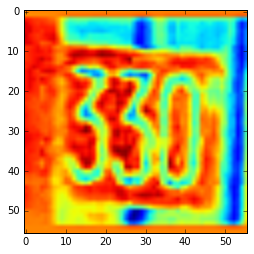

Labels [2 7 6]
Dtype float32
Shape (56, 56)
Color range -0.50997 0.5


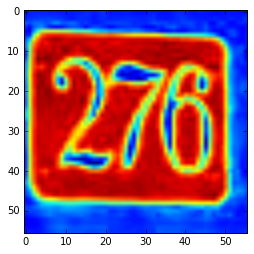

Labels [2 0 5]
Dtype float32
Shape (56, 56)
Color range -0.504495 0.5


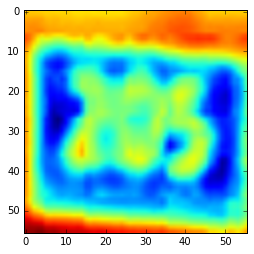

Labels [1 3]
Dtype float32
Shape (56, 56)
Color range -0.493705 0.5


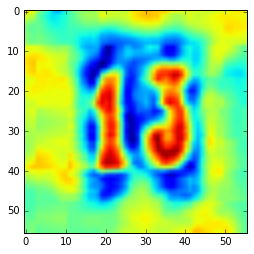

Labels [1 4 3 2]
Dtype float32
Shape (56, 56)
Color range -0.503324 0.5


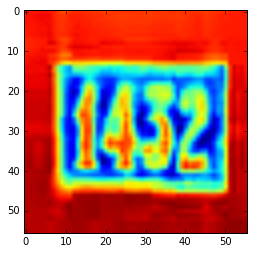

Labels [2 1]
Dtype float32
Shape (56, 56)
Color range -0.535308 0.5


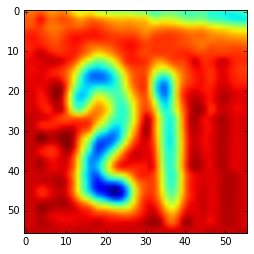

In [5]:
for dataset, labels in [(train_dataset_56, train_labels),
                        (valid_dataset_56, valid_labels),
                        (test_dataset_56, test_labels)]:
    show_images(dataset, labels, 2)

In [6]:
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale
num_digits = 5

def reformat(dataset, labels):
    dataset_output = dataset.reshape(list(dataset.shape) + [1]).astype(np.float32)
    labels_output = np.array([np.array([(np.arange(num_labels) == l).astype(np.float32) 
                        for l in np.append(row, [num_labels-1] * (num_digits - len(row)), 0)])
              for row in labels])
    return dataset_output, labels_output

train_dataset_56, train_labels = reformat(train_dataset_56, train_labels)
valid_dataset_56, valid_labels = reformat(valid_dataset_56, valid_labels)
test_dataset_56, test_labels = reformat(test_dataset_56, test_labels)

print('Training set', train_dataset_56.shape, train_labels.shape)
print('Validation set', valid_dataset_56.shape, valid_labels.shape)
print('Test set', test_dataset_56.shape, test_labels.shape)

Training set (26149, 56, 56, 1) (26149, 5, 11)
Validation set (2000, 56, 56, 1) (2000, 5, 11)
Test set (13068, 56, 56, 1) (13068, 5, 11)


In [8]:
#Limit test set as it's killing the box
test_dataset_56 = test_dataset_56[:6000]
test_labels = test_labels[:6000]

# Create a pit sized 
train_dataset_28 = train_dataset_56[:, ::2, ::2, :]
valid_dataset_28 = valid_dataset_56[:, ::2, ::2, :]
test_dataset_28 = test_dataset_56[:, ::2, ::2, :]
print('Training set', train_dataset_28.shape, train_labels.shape)
print('Validation set', valid_dataset_28.shape, valid_labels.shape)
print('Test set', test_dataset_28.shape, test_labels.shape)

Training set (26149, 28, 28, 1) (26149, 5, 11)
Validation set (2000, 28, 28, 1) (2000, 5, 11)
Test set (6000, 28, 28, 1) (6000, 5, 11)


In [9]:
dataset_56 = (train_dataset_56, valid_dataset_56, test_dataset_56)
dataset_28 = (train_dataset_28, valid_dataset_28, test_dataset_28)

In [10]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_list(predictions, labels):
    result = np.mean([accuracy(predictions[i],
                               labels[:, i, :])
                        for i in range(num_digits)])
    return result

def run_graph(graph, train_dataset):
    start_time = time.time()
    
    num_steps = 1000001
    save_steps = 100000
    eval_steps = 1000
    valid_steps = 1000
    timeout =  30 * 60 # 30 minutes * 60 seconds

    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        saver = tf.train.Saver()
        print('Initialized')
        for step in range(num_steps):
            
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]


            feed_dict = {tf_train_labels[i] : batch_labels[:, i, :] for i in range(num_digits)}
            feed_dict[tf_train_dataset] = batch_data        


            fetches = [optimizer, loss]
            results = session.run(fetches, feed_dict=feed_dict)


            elapsed_time = time.time() - start_time
            timeup = elapsed_time >= timeout
            
            if step > 0 or timeup:
                if (step % eval_steps == 0 or timeup):
                    print('Elapsed time(s):%d/%d (%.2f%%)' % (elapsed_time, timeout, 1.0 * elapsed_time / timeout))
                    if timeup:
                        print("\nTIMEUP!")
                    print('Learning rate:', learning_rate.eval())
                    print('Minibatch loss at step %d: %f' % (step, results[1]))

                    fetches = train_prediction
                    results = session.run(fetches, feed_dict={tf_train_dataset : batch_data})
                    train_accuracy = accuracy_list(
                        results,
                        batch_labels)

                    print('Minibatch accuracy: %.1f%%' % train_accuracy)
            
                if (step % valid_steps == 0 or timeup):
                    valid_accuracy = accuracy_list(
                        [valid_prediction[i].eval() for i in range(num_digits)],
                        valid_labels)
                    print('Validation accuracy: %.1f%%' % valid_accuracy)

                if step % save_steps == 0 or timeup:
                    test_accuracy = accuracy_list(
                        [test_prediction[i].eval() for i in range(num_digits)],
                        test_labels)
                    print('Test accuracy: %.1f%%' % test_accuracy)
                    
            if timeup:
                break

        print("Creating outputs")
    #     output = {
    #         'layer_1' : layer1_weights.eval(),
    #         'layer_2' : layer2_weights.eval(),
    #         'layer_3' : layer3_weights.eval(),
    #     }
    print("Finished")

In [12]:
batch_size = 16

patch_size = 5
depth = 16

# Taken from tensorflow tutorial
num_hidden = 64

graph = tf.Graph()
stddev = 0.1

train_dataset, valid_dataset, test_dataset = dataset_28

img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    tmp_size = img_width * img_height * depth
    layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                 name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")

    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data):
        conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset)
    
    loss = tf.reduce_mean([
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        )for i in range(num_digits)])
                       
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph, train_dataset)

28 28
Initialized
Elapsed time(s):14/1800 (0.01%)
Learning rate: 0.0497417
Minibatch loss at step 1000: 1.224651
Minibatch accuracy: 60.0%
Validation accuracy: 63.3%
Elapsed time(s):31/1800 (0.02%)
Learning rate: 0.0494849
Minibatch loss at step 2000: 1.152493
Minibatch accuracy: 65.0%
Validation accuracy: 65.1%
Elapsed time(s):47/1800 (0.03%)
Learning rate: 0.0492295
Minibatch loss at step 3000: 0.908390
Minibatch accuracy: 67.5%
Validation accuracy: 68.1%
Elapsed time(s):63/1800 (0.04%)
Learning rate: 0.0489754
Minibatch loss at step 4000: 0.898085
Minibatch accuracy: 75.0%
Validation accuracy: 71.2%
Elapsed time(s):79/1800 (0.04%)
Learning rate: 0.0487226
Minibatch loss at step 5000: 0.940741
Minibatch accuracy: 76.2%
Validation accuracy: 73.3%
Elapsed time(s):96/1800 (0.05%)
Learning rate: 0.0484711
Minibatch loss at step 6000: 0.511743
Minibatch accuracy: 85.0%
Validation accuracy: 75.4%
Elapsed time(s):112/1800 (0.06%)
Learning rate: 0.0482209
Minibatch loss at step 7000: 0.76398

In [11]:
batch_size = 16

patch_size = 5
depth = 16

# Taken from tensorflow tutorial
num_hidden = 64

graph = tf.Graph()
stddev = 0.1

train_dataset, valid_dataset, test_dataset = dataset_28
img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    tmp_size = img_width * img_height * depth
    layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                 name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")

    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        if dropout: conv = tf.nn.dropout(conv, 0.75)
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.reduce_mean([
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        )for i in range(num_digits)])
                       
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph, train_dataset)

28 28
Initialized
Elapsed time(s):18/1800 (0.01%)
Learning rate: 0.0497417
Minibatch loss at step 1000: 1.298704
Minibatch accuracy: 57.5%
Validation accuracy: 62.0%
Elapsed time(s):37/1800 (0.02%)
Learning rate: 0.0494849
Minibatch loss at step 2000: 1.353999
Minibatch accuracy: 61.2%
Validation accuracy: 62.4%
Elapsed time(s):57/1800 (0.03%)
Learning rate: 0.0492295
Minibatch loss at step 3000: 1.151164
Minibatch accuracy: 62.5%
Validation accuracy: 63.7%
Elapsed time(s):76/1800 (0.04%)
Learning rate: 0.0489754
Minibatch loss at step 4000: 1.046781
Minibatch accuracy: 68.8%
Validation accuracy: 63.9%
Elapsed time(s):96/1800 (0.05%)
Learning rate: 0.0487226
Minibatch loss at step 5000: 1.174925
Minibatch accuracy: 62.5%
Validation accuracy: 64.7%
Elapsed time(s):115/1800 (0.06%)
Learning rate: 0.0484711
Minibatch loss at step 6000: 0.986039
Minibatch accuracy: 68.8%
Validation accuracy: 65.8%
Elapsed time(s):135/1800 (0.08%)
Learning rate: 0.0482209
Minibatch loss at step 7000: 1.0277

In [13]:
batch_size = 16

patch_size = 5
depth = 16

# Taken from tensorflow tutorial
num_hidden = 64

graph = tf.Graph()
stddev = 0.1

train_dataset, valid_dataset, test_dataset = dataset_28
img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    tmp_size = img_width * img_height * depth
    layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                 name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")

    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        if dropout: conv = tf.nn.dropout(conv, 0.75)
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.reduce_mean([
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        )for i in range(num_digits)])
                       
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):18/1800 (0.01%)
Learning rate: 0.497417
Minibatch loss at step 1000: 1.230350
Minibatch accuracy: 63.8%
Validation accuracy: 64.3%
Elapsed time(s):38/1800 (0.02%)
Learning rate: 0.494849
Minibatch loss at step 2000: 1.341131
Minibatch accuracy: 66.2%
Validation accuracy: 67.7%
Elapsed time(s):58/1800 (0.03%)
Learning rate: 0.492295
Minibatch loss at step 3000: 0.976625
Minibatch accuracy: 67.5%
Validation accuracy: 68.2%
Elapsed time(s):78/1800 (0.04%)
Learning rate: 0.489754
Minibatch loss at step 4000: 1.066255
Minibatch accuracy: 71.2%
Validation accuracy: 69.6%
Elapsed time(s):98/1800 (0.05%)
Learning rate: 0.487226
Minibatch loss at step 5000: 1.091597
Minibatch accuracy: 68.8%
Validation accuracy: 71.0%
Elapsed time(s):118/1800 (0.07%)
Learning rate: 0.484711
Minibatch loss at step 6000: 0.941802
Minibatch accuracy: 78.8%
Validation accuracy: 71.7%
Elapsed time(s):140/1800 (0.08%)
Learning rate: 0.482209
Minibatch loss at step 7000: 0.972476
Minibatch 

In [ ]:
batch_size = 16

patch_size = 5
depth = 16

# Taken from tensorflow tutorial
num_hidden = 64

graph = tf.Graph()
stddev = 0.1

train_dataset, valid_dataset, test_dataset = dataset_28
img_height, img_width = train_dataset[0].shape[:2]

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    tmp_size = img_width * img_height * depth
    layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                 name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")

    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        if dropout: conv = tf.nn.dropout(conv, 0.75)
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.reduce_mean([
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        )for i in range(num_digits)])
                       
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.296)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph, train_dataset)

Initialized
Elapsed time(s):18/1800 (0.01%)
Learning rate: 0.0493944
Minibatch loss at step 1000: 1.316615
Minibatch accuracy: 58.8%
Validation accuracy: 61.9%
Elapsed time(s):38/1800 (0.02%)
Learning rate: 0.0487967
Minibatch loss at step 2000: 1.382053
Minibatch accuracy: 61.2%
Validation accuracy: 62.5%
Elapsed time(s):58/1800 (0.03%)
Learning rate: 0.0482063
Minibatch loss at step 3000: 1.106134
Minibatch accuracy: 67.5%
Validation accuracy: 63.0%
Elapsed time(s):78/1800 (0.04%)
Learning rate: 0.047623
Minibatch loss at step 4000: 1.029276
Minibatch accuracy: 68.8%
Validation accuracy: 64.2%
Elapsed time(s):97/1800 (0.05%)
Learning rate: 0.0470467
Minibatch loss at step 5000: 1.177890
Minibatch accuracy: 63.8%
Validation accuracy: 64.8%

In [ ]:
batch_size = 16

patch_size = 5
depth = 16

# Taken from tensorflow tutorial
num_hidden = 64

graph = tf.Graph()
stddev = 0.1

train_dataset, valid_dataset, test_dataset = dataset_56
img_height, img_width = train_dataset[0].shape[:2]

img_height, img_width = test_dataset[0].shape[:2]

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")

    tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                         num_labels), name="tf_train_labels_%d" % i)
                       for i in range(num_digits)]

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=stddev), name="layer1_weights")
    layer1_biases = tf.Variable(tf.constant(0.1, shape=[depth]), name="layer1_biases")

    tmp_size = img_width * img_height * depth
    layer2_weights = tf.Variable(tf.truncated_normal([tmp_size, num_hidden], stddev=stddev),
                                 name="layer2_weights")
    layer2_biases = tf.Variable(tf.constant(0.1, shape=[num_hidden]), name="layer2_biases")

    
    layer4_weights = tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels * num_digits], stddev=stddev), name="layer4_weights")
    layer4_biases = tf.Variable(tf.ones(shape=[num_labels * num_digits]), name="layer4_biases")

    # Model.
    def model(data, dropout=False):
        if dropout: data = tf.nn.dropout(data, 0.9)
            
        conv = tf.nn.relu(tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME') + layer1_biases)
        if dropout: conv = tf.nn.dropout(conv, 0.75)
        
        shape = conv.get_shape().as_list()
        reshape = tf.reshape(conv, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer2_weights) + layer2_biases)
        if dropout: hidden = tf.nn.dropout(hidden, 0.5)
            
        output = tf.matmul(hidden, layer4_weights) + layer4_biases
                
        split_logits = tf.split(1, num_digits, output)
        return split_logits

    # Training computation.
    logits = model(tf_train_dataset, True)
    
    loss = tf.reduce_mean([
                        tf.nn.softmax_cross_entropy_with_logits(
                            logits[i],
                            tf_train_labels[i]
                        )for i in range(num_digits)])
                       
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.05, global_step, 100000, 0.596)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

  
    # Predictions for the training, validation, and test data.
    train_prediction = [tf.nn.softmax(model(tf_train_dataset)[i]) for i in range(num_digits)]
    
    tf_valid_dataset = tf.constant(valid_dataset, name="tf_valid_dataset")
    valid_prediction = [tf.nn.softmax(model(tf_valid_dataset)[i]) for i in range(num_digits)]
    
    tf_test_dataset = tf.constant(test_dataset, name="tf_test_dataset")
    test_prediction = [tf.nn.softmax(model(tf_test_dataset)[i]) for i in range(num_digits)]
    
    
run_graph(graph, train_dataset)